## Task 15 - Motor Control
### Introduction to modeling and simulation of human movement
https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md

Desiree Miraldo  

* Task (for Lecture 15):

Write a Python Class to implement the muscle model developed during the course.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

%matplotlib notebook

### Subject's anthropometrics

From Thelen(2003) - dorsiflexors:

Using BSP values from Dempster's model adapted by Winter (2009), available in [BodySegmentParameters.ipynb](https://github.com/BMClab/bmc/blob/master/notebooks/BodySegmentParameters.ipynb)

In [2]:
m = 75 #kg
g = 9.81 #(m/s^2)
Lfoot = 26e-2 #(m)
mfoot = 0.0145*m #0.0145 from column Mass (kg)
Rcm = 0.5* Lfoot #0.5 from column CM prox (m)
Ifoot = mfoot*(.69*Lfoot)**2 #0.690 from column Rg prox (kg*m^2)


### Initial conditions

In [3]:
phi = 0 #start as 0 degree flexion (rad)
phid = 0 #zero velocity
t0 = 0 #Initial time
tf = .5 #Final Time
h = 1e-4 #integration step size and step counter

In [4]:
t = np.arange(t0,tf,h)
F = np.empty(t.shape)
Fkpe = np.empty(t.shape)
FiberLen = np.empty(t.shape)
TendonLen = np.empty(t.shape)
a_dynamics = np.empty(t.shape)
phi_dynamics = np.empty(t.shape)
fiberVelocity = np.empty(t.shape)
moment     = np.empty(t.shape)

#### Activation dynamics parameters

In [5]:
a = 1 #inital conditional for ativation

In [6]:
# defining u (Initial conditional for Brain's activation)
form = 'step'

def createinput_u(form,t,h=.01,plot=True):
    if (form == 'sinusoid'):
        u = .2*np.sin(np.pi*t) +.7
    elif (form == 'step'):
        u = np.ones(t.shape)*h
        u[:int(1/h)] = 0
        u[int(1/h):int(3/h)] = 1

    elif (form == 'pulse'):
        u = np.ones(t.shape)*h
        u[int(1/h):int(3/h)] = 1

    if plot:
        plt.figure()
        plt.plot(u)
        plt.title('u wave form')
    return u   

#u = createinput_u(form,h)
u = np.ones(t.shape)/1

#### Coeficients from Elias(2014)

In [7]:
A = np.array([30.60,-7.44e-2,-1.41e-4,2.42e-6,1.50e-8])*1e-2 #parameters from Elias(2014) (meter/deg^ind)
B = np.array([4.30,1.66e-2,-3.89e-4,-4.45e-6,-4.34e-8])*1e-2 #parameters from Elias(2014) (meter/deg^ind)

### Class (OOP)

In [8]:
class Muscle:
    
    def __init__(self, Lce_o, Lslack, alpha, Fmax):
         
        self.Lce_o = Lce_o   # optimal length
        self.Lslack = Lslack*self.Lce_o # slack length
        self.alpha = alpha   # pennation angle (rad) 
        self.Fmax = Fmax     # maximal isometric force
        
        # Muscle parameters from Nigg & Herzog (2006):
        self.UmaxTendon = .04 
        self.Umax_kpe = 1
        self.width = .63
        
    def tendonLength(self, Lm,Lnorm_ce):
        '''
        Compute tendon length
    
        Inputs:
            Lm = 
            Lce_o = optimal length of the fiber
            Lnorm_ce = normalized contractile element length
    
        Output:
            Lnorm_see = normalized tendon length   
        '''
        
        Lnorm_see = Lm/self.Lce_o - Lnorm_ce*np.cos(self.alpha)
        
        return Lnorm_see
    
    def TendonForce(self,Lnorm_see):
        '''
        Compute tendon force

        Inputs:
            Lnorm_see = normalized tendon length
            Lslack = slack length of the tendon (non-normalized)
            Lce_o = optimal length of the fiber
    
        Output:
            Fnorm_tendon = normalized tendon force
        
        '''
            
        if Lnorm_see<self.Lslack/self.Lce_o: 
            Fnorm_tendon = 0
        else: 
            Fnorm_tendon = ((Lnorm_see-self.Lslack/self.Lce_o)/(self.UmaxTendon*self.Lslack/self.Lce_o))**2
        
        return Fnorm_tendon
    
    def ParallelElementForce(self,Lnorm_ce):
        '''
        Compute parallel element force

        Inputs:
            Lnorm_ce = normalized contractile element length

        Output:
            Fnorm_kpe = normalized parallel element force

        '''

        if Lnorm_ce< 1: 
            Fnorm_kpe = 0
        else: 
            Fnorm_kpe = ((Lnorm_ce-1)/(self.Umax_kpe*1))**2 

        return Fnorm_kpe
    
    def ForceLengthCurve(self,Lnorm_ce):
        '''
        Compute Force-Length Curve
        
        Inputs:
            Lnorm_ce = normalized contractile element length
            
        Output:
            F0 = Force-Length Curve
            
            '''
        
        F0 = max([0, (1-((Lnorm_ce-1)/self.width)**2)])
        
        return F0
    
    def ContractileElementForce(self,Fnorm_tendon,Fnorm_kpe):
        '''
        Compute Contractile Element force

        Inputs:
            Fnorm_tendon = normalized tendon force
            Fnorm_kpe = normalized parallel element force

        Output:
            Fnorm_CE = normalized contractile element force
        '''
        
        Fnorm_CE = Fnorm_tendon/np.cos(self.alpha) - Fnorm_kpe
        
        return Fnorm_CE
    
    def ContractileElementDot(self,F0,Fnorm_ce, a,Vmax=10, FMlen = 1.4, Af = 0.25):

        '''
        Compute Contractile Element Derivative

        Inputs:
            F0 = Force-Length Curve
            Fce = Contractile element force
            Vmax = maximum muscle velocity for concentric activation
            FMlen = normalized maximum force generated at the lengthening phase
            Af = shape factor

        Output:
            Lnorm_cedot = normalized contractile element length derivative

        '''

        Fnorm_ce = min(FMlen*a*F0 - 0.001, Fnorm_ce)

        if  Fnorm_ce > a*F0:

            b = ((2 + 2/Af)*(a*F0*FMlen - Fnorm_ce))/(FMlen-1)

        elif Fnorm_ce <= a*F0:

            b = a*F0 + Fnorm_ce/Af

        Lnorm_cedot = (.25 + .75*a)*Vmax*((Fnorm_ce - a*F0)/b)

        return Lnorm_cedot
    
    def ForceVelocityCurve(self,vel_ce,a, F0, Fnorm_ce, Vmax=10, FMlen = 1.4, Af = 0.25):
        '''
        Compute Force Velocity curve

        Inputs:
            vel_ce = contractile element velocity
            a = muscle activation level
            F0 = Force-Length Curve
            Fnorm_ce = Contractile element force
            Vmax = maximum muscle velocity for concentric activation
            FMlen = normalized maximum force generated at the lengthening phase
            Af = shape factor

        Output:
            FVnorm_ce = normalized force of the muscle contractile element

        '''

        Vmax = Vmax*Lce_o
        if vel_ce <= 0:  # isometric and concentric activation
            FVnorm_ce = Af*F0*a*(Vmax*(3.0*a + 1) + 4.0*vel_ce)/(Vmax*(3.0*Af*a + Af) - 4.0*vel_ce)
        else:        # eccentric activation
            FVnorm_ce = F0*a*(Af*Vmax*(3.0*FMlen*a + FMlen - 3.0*a - 1) + FMlen*(8.0*Af*vel_ce + 8.0*vel_ce))/(Af*Vmax*(3.0*FMlen*a + FMlen - 3.0*a - 1) + vel_ce*(8.0*Af + 8.0))

        return FVnorm_ce

In [9]:
# Using muscle specific parameters from Thelen(2003) - Table 2

dorsiflexor = Muscle(Lce_o=.09, Lslack=2.4, alpha=7*np.pi/180, Fmax=1400)
soleus = Muscle(Lce_o=.03, Lslack=8.8, alpha=25*np.pi/180, Fmax=3150)
gastroc = Muscle(Lce_o=.05, Lslack=8.3, alpha=14*np.pi/180, Fmax=1750)
plantarflexor = Muscle(Lce_o=.031, Lslack=10, alpha=12*np.pi/180, Fmax=3150)

In [10]:
#Dorsiflexor

#Lnorm_ce = .087/dorsiflexor.Lce_o #normalized
Lnorm_ce = (.306-(dorsiflexor.Lslack)/np.cos(dorsiflexor.alpha))/dorsiflexor.Lce_o
Fmax = dorsiflexor.Fmax
Lce_o = dorsiflexor.Lce_o

## Functions

In [11]:
def totalMuscleLength(phi,A):
    '''
    Compute length Muscle+tendon - Eq. 8 from Elias(2014)
    
    Inputs:
        A = parameters from Elias(2014) (meter/deg^ind)
        thetaAnkle = angle of ankle
    Output:
        Lm = length Muscle+tendon
    
    '''
    phi = phi*180/np.pi
    
    Lm = 0
    for i in range(len(A)):
        Lm += A[i]*(phi**i)
    
    return Lm   
    

In [12]:
def activation(a,u,dt):
    '''
    Compute activation
    
    Inputs:
        u = idealized muscle excitation signal, 0 <= u <= 1
        a = muscular activation
        dt = time step
    
    Output:
        a = muscular activation  
    '''
    
    tau_deact = 50e-3 #young adults
    tau_act = 15e-3
    
    if u>a:
        tau_a = tau_act*(0.5+1.5*a)
    elif u <=a:
        tau_a = tau_deact/(0.5+1.5*a)
    
    #-------
    dadt = (u-a)/tau_a # euler
    
    a = a + dadt*dt
    #-------
    return a

In [13]:
def momentArm(phi,B):
    '''
    Compute moment arm of muscle - Eq. 9 from Elias(2014)
    
    Inputs:
        A = parameters from Elias(2014) (meter/deg^ind)
        B = parameters from Elias(2014) (meter/deg^ind)
    Output:
        Lm = length Muscle+tendon
    '''
    
    phi = phi*180/np.pi
    
    Rf = 0
    for i in range(len(B)):
        Rf += B[i]*(phi**i) #Eq. 9 from Elias(2014)
    
    return Rf   
    

In [14]:
def momentJoint(Rf,Fnorm_tendon,Fmax,m,g,phi):
    '''
    Inputs:
        Rf = Moment arm
        Fnorm_tendon = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
        phi = angle (deg)
    Output:
        M = Total moment with respect to joint
    '''
    M=Rf*Fnorm_tendon*Fmax - m*g*Rcm*np.sin(np.pi/2-phi)
    return M

In [15]:
def angularAcelerationJoint(M,I):
    '''
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        phidd= angular aceleration of the joint
    '''
    phidd = M/I
    return phidd

### Check initial conditions

## Simulation - Parallel

In [16]:
#Normalizing
for i in range(len(t)):
    
    Lm =  totalMuscleLength(phi,A)
    
    # -----------------------------------------------------
    Lnorm_see = dorsiflexor.tendonLength(Lm,Lnorm_ce)

    Fnorm_tendon = dorsiflexor.TendonForce(Lnorm_see) 
    
    Fnorm_kpe = dorsiflexor.ParallelElementForce(Lnorm_ce)     
        
    #isometric force at Lce from CE force length relationship
    F0 = dorsiflexor.ForceLengthCurve(Lnorm_ce)
    
    Fnorm_CE = dorsiflexor.ContractileElementForce(Fnorm_tendon,Fnorm_kpe) #Fnorm_CE = ~Fm  
    
    #computing activation
    a = activation(a,u[i],h)
    
    #calculate CE velocity from Hill's equation    
    Lnorm_cedot = dorsiflexor.ContractileElementDot(F0, Fnorm_CE,a)
    
    # -----------------------------------------------------
    
    #Compute MomentJoint
    Rf = momentArm(phi,B) #moment arm
    M = momentJoint(Rf,Fnorm_tendon,Fmax,mfoot,g,phi)
    
    #Compute Angular Aceleration Joint
    phidd = angularAcelerationJoint(M,Ifoot)
    
    #Euler integration steps
    Lnorm_ce = Lnorm_ce + h*Lnorm_cedot
    phid= phid + h*phidd
    phi  = phi  +h*phid

    # Store variables in vectors
    F[i] = Fnorm_tendon*Fmax
    Fkpe[i] = Fnorm_kpe*Fmax
    FiberLen[i] = Lnorm_ce*Lce_o
    TendonLen[i] = Lnorm_see*Lce_o
    a_dynamics[i] = a
    phi_dynamics[i] = phi
    fiberVelocity[i] = Lnorm_cedot*Lce_o
    moment[i] = M

## Plots 

<IPython.core.display.Javascript object>


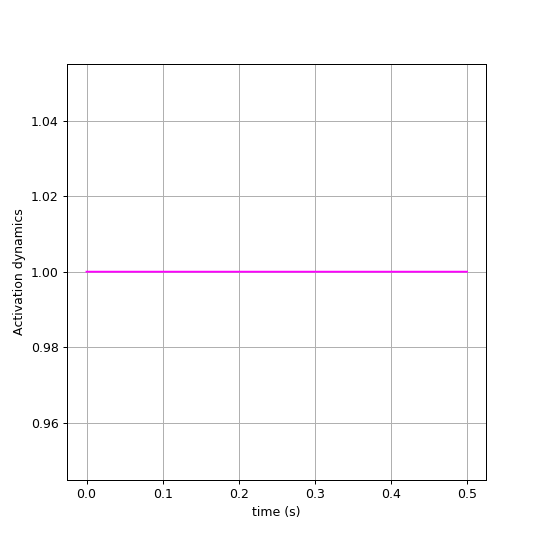

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,a_dynamics,c='magenta')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Activation dynamics');

<IPython.core.display.Javascript object>


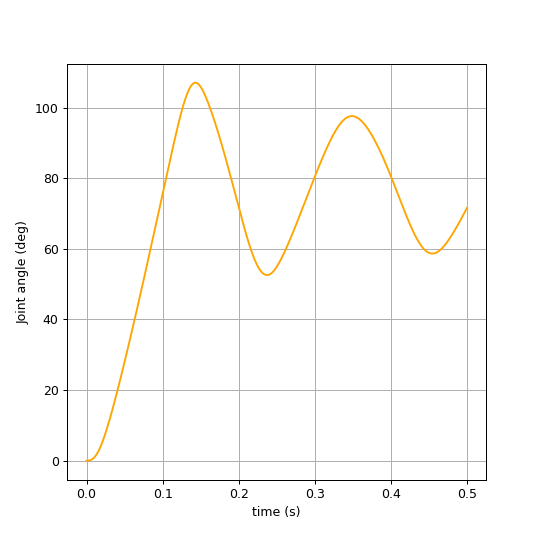

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,phi_dynamics*180/np.pi ,c='orange')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Joint angle (deg)');

<IPython.core.display.Javascript object>


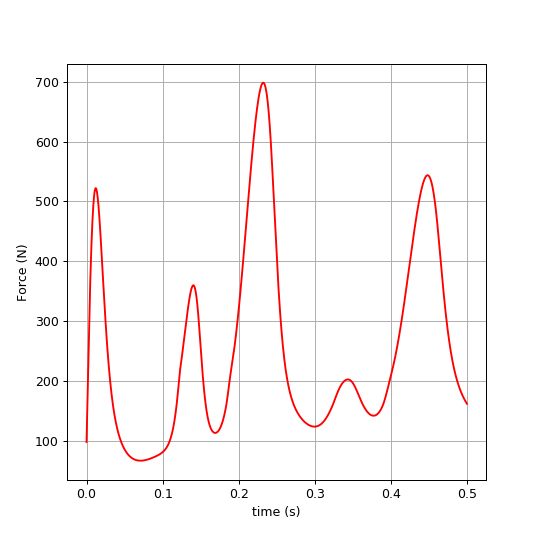

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,F,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)');

<IPython.core.display.Javascript object>


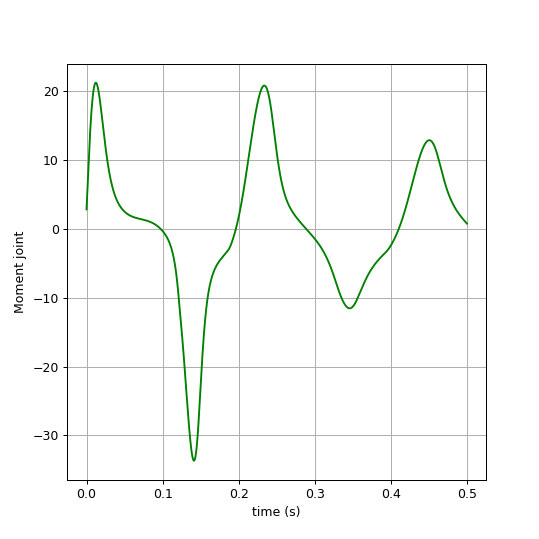

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,moment,c='green')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Moment joint');

<IPython.core.display.Javascript object>


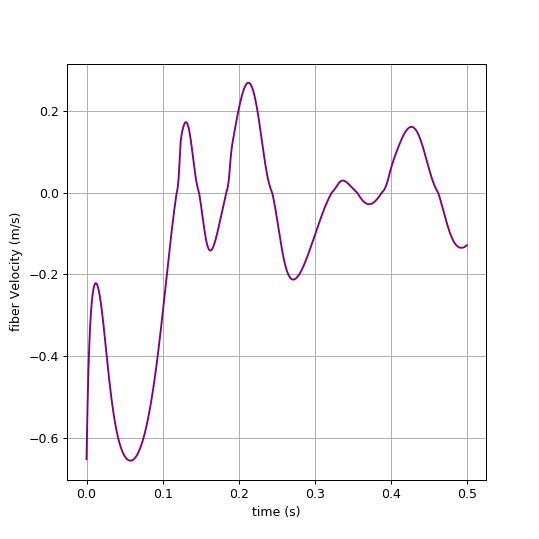

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,fiberVelocity,c='purple')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('fiber Velocity (m/s)');

<IPython.core.display.Javascript object>


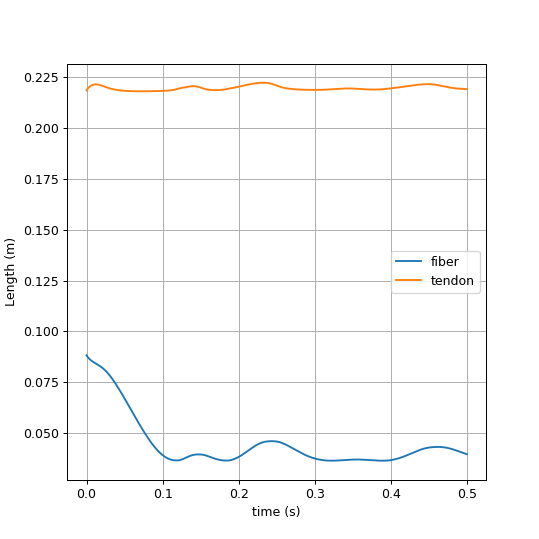

<IPython.core.display.Javascript object>


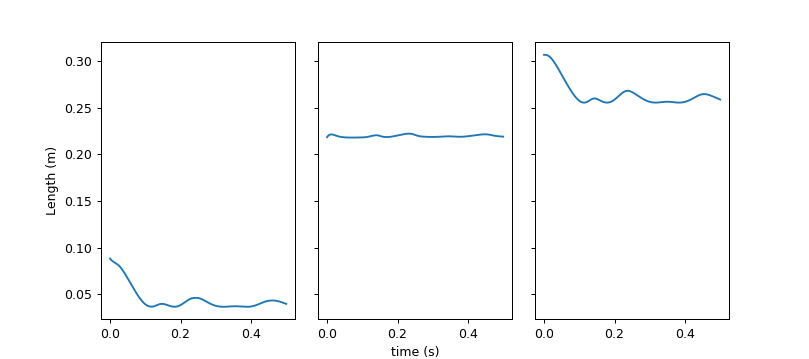

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,FiberLen, label = 'fiber')
ax.plot(t,TendonLen, label = 'tendon')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Length (m)')
ax.legend(loc='best')


fig, ax = plt.subplots(1, 3, figsize=(9,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.12, hspace=None,left=None, bottom=None, right=None, top=None,)
ax[0].plot(t,FiberLen, label = 'fiber')
ax[1].plot(t,TendonLen, label = 'tendon')
ax[2].plot(t,FiberLen + TendonLen, label = 'muscle (tendon + fiber)')

ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('Length (m)');
#ax[i].legend(loc='best')